In [51]:
import numpy as np
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import logging
import struct
import json
import pathlib
from typing import List

# These imports are needed for the full compressor class, though not all are used in this specific analysis
import tensorly as tl
from sklearn.decomposition import IncrementalPCA
from tensorly.decomposition import parafac

from wavelet_better import wavedec3, waverec3, quantise, dequantise, compute_rmse

# Configure basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# For nicer DataFrame display in certain environments
try:
    # Use ace_tools if available, otherwise fallback to simple print
    import ace_tools
    def display_df(name: str, df: pd.DataFrame):
        """Displays a pandas DataFrame to the user."""
        ace_tools.display_dataframe_to_user(name=name, dataframe=df)
except ImportError:
    logging.info("ace_tools not found, falling back to print() for DataFrames.")
    def display_df(name: str, df: pd.DataFrame):
        """Fallback display function for DataFrames."""
        print(f"\n--- {name} ---\n")
        print(df)
        print("\n" + "-" * (len(name) + 8) + "\n")


2025-08-01 00:01:09,221 - INFO - ace_tools not found, falling back to print() for DataFrames.


In [52]:
def create_synthetic_volume(size: int = 64) -> np.ndarray:
    """Creates a synthetic 3D volume with a smooth blob and some high-frequency detail."""
    coords = np.linspace(-1, 1, size)
    x, y, z = np.meshgrid(coords, coords, coords, indexing='ij')
    # Smooth Gaussian blob
    sigma = 0.3
    gauss = np.exp(-(x**2 + y**2 + z**2) / (2 * sigma**2))
    # High-frequency sphere
    sphere = ((x**2 + y**2 + z**2) < 0.5**2).astype(np.float32)
    volume = gauss + 0.3 * sphere
    return volume.astype(np.float32)

def compute_energy_per_level(coeffs_struct: list) -> pd.DataFrame:
    """
    Given pywt wavedecn coeffs list, computes energy per level and returns a DataFrame.
    """
    energies = {}
    # coeffs[0] is the approximation (LL...) at the deepest level
    approx = coeffs_struct[0]
    energies['approximation'] = np.sum(approx.astype(np.float32)**2)
    
    # The rest are detail coefficients, from finest (L1) to coarsest
    num_levels = len(coeffs_struct) - 1
    for i, detail in enumerate(coeffs_struct[1:], start=1):
        level_energy = 0.0
        for arr in detail.values():
            level_energy += np.sum(arr.astype(np.float32)**2)
        energies[f'detail_L{num_levels - i + 1}'] = level_energy
        
    energy_df = pd.DataFrame.from_dict(energies, orient='index', columns=['energy'])
    total_energy = energy_df['energy'].sum()
    energy_df['fraction'] = energy_df['energy'] / total_energy if total_energy > 0 else 0
    return energy_df.sort_index()

def run_thresholding_analysis(
    original_volume: np.ndarray,
    coeff_array: np.ndarray,
    coeff_slices,
    wavelet: str,
    thresholds_pct: List[float]
) -> pd.DataFrame:
    """
    Performs a thresholding experiment by keeping the top X% of coefficients.
    
    Returns a DataFrame with RMSE and other metrics for each threshold.
    """
    flat_coeffs = coeff_array.ravel()
    total_coeffs = flat_coeffs.size
    
    # Get indices of coefficients sorted by descending magnitude
    sorted_indices = np.argsort(np.abs(flat_coeffs))[::-1]
    
    results = []
    for pct in thresholds_pct:
        n_coeffs_to_keep = int(total_coeffs * (pct / 100.0))
        
        # Create a mask to keep only the top coefficients
        mask = np.zeros_like(flat_coeffs, dtype=bool)
        if n_coeffs_to_keep > 0:
            mask[sorted_indices[:n_coeffs_to_keep]] = True
            
        # Create the truncated coefficient array
        truncated_flat = np.zeros_like(flat_coeffs)
        truncated_flat[mask] = flat_coeffs[mask]
        truncated_array = truncated_flat.reshape(coeff_array.shape)
        
        # Reconstruct the volume from the truncated coefficients
        reconstructed_volume = waverec3(truncated_array, coeff_slices, wavelet)
        
        # Calculate metrics
        rmse = compute_rmse(original_volume, reconstructed_volume)
        
        results.append({
            'kept_pct': pct,
            'kept_coeffs': n_coeffs_to_keep,
            'total_coeffs': total_coeffs,
            'rmse': rmse,
        })
        
    return pd.DataFrame(results)

In [53]:
# Data parameters
VOLUME_SIZE = 256

# Wavelet parameters
WAVELET_TYPE = 'db4'  # e.g., 'haar', 'db2', 'db4', 'sym4'
WAVELET_LEVEL = 4     # Number of decomposition levels

# Analysis parameters
THRESHOLDS_PCT = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100] # Percentage of coeffs to keep

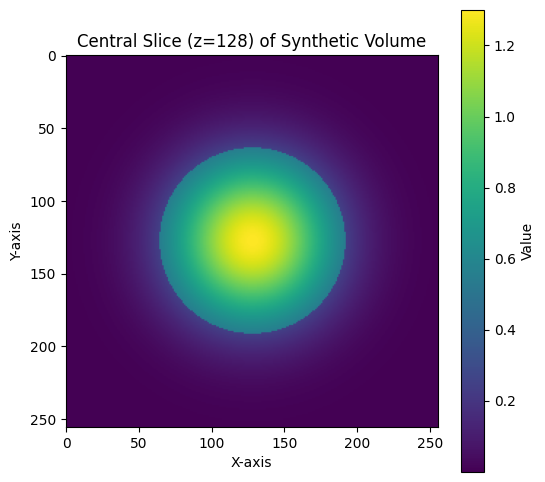

In [54]:
# Generate the data
np.random.seed(42)
volume = create_synthetic_volume(size=VOLUME_SIZE)

# Visualize a central slice
slice_idx = VOLUME_SIZE // 2
plt.figure(figsize=(6, 6))
plt.imshow(volume[:, :, slice_idx], cmap='viridis')
plt.title(f'Central Slice (z={slice_idx}) of Synthetic Volume')
plt.colorbar(label='Value')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

Volume shape: (256, 256, 256)
Flattened coefficient array shape: (256, 256, 256)

--- Energy Distribution (db4, L4) ---

                      energy  fraction
approximation  705298.562500  0.990509
detail_L1         807.667603  0.001134
detail_L2         869.265503  0.001221
detail_L3        1734.056396  0.002435
detail_L4        3347.027832  0.004701

-------------------------------------



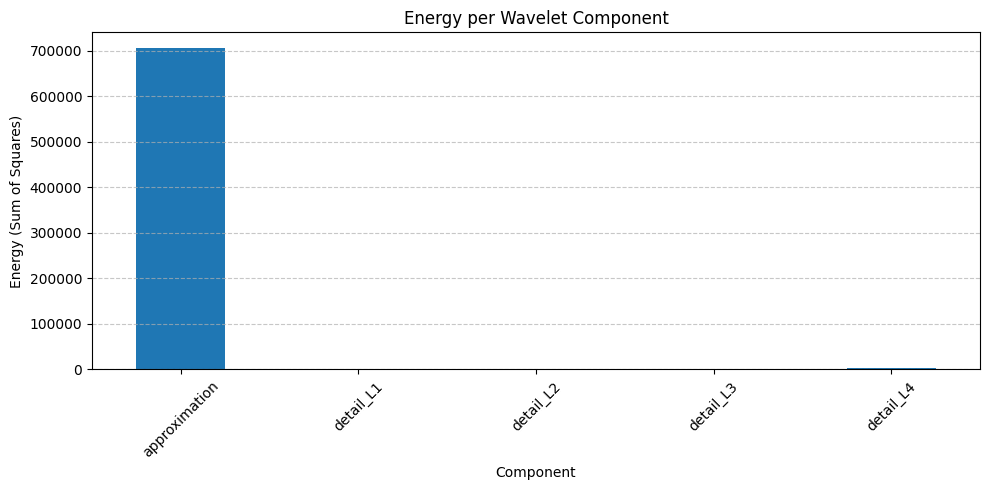

In [55]:
# Perform the 3D wavelet decomposition
coeff_array, coeff_slices, coeffs_struct = wavedec3(
    volume, wavelet=WAVELET_TYPE, level=WAVELET_LEVEL
)
print(f"Volume shape: {volume.shape}")
print(f"Flattened coefficient array shape: {coeff_array.shape}")

# Analyze energy distribution
energy_df = compute_energy_per_level(coeffs_struct)
display_df(f"Energy Distribution ({WAVELET_TYPE}, L{WAVELET_LEVEL})", energy_df)

# Plot the energy distribution
plt.figure(figsize=(10, 5))
energy_df['energy'].plot(kind='bar')
plt.title('Energy per Wavelet Component')
plt.ylabel('Energy (Sum of Squares)')
plt.xlabel('Component')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



--- Thresholding RMSE vs. Kept Coefficients ---

   kept_pct  kept_coeffs  total_coeffs          rmse
0       0.1        16777      16777216  7.352469e-03
1       0.5        83886      16777216  2.884916e-03
2       1.0       167772      16777216  1.211313e-03
3       2.0       335544      16777216  1.953216e-04
4       5.0       838860      16777216  5.014348e-07
5      10.0      1677721      16777216  1.112331e-07
6      20.0      3355443      16777216  1.048485e-07
7      50.0      8388608      16777216  1.047048e-07
8     100.0     16777216      16777216  1.047059e-07

-----------------------------------------------



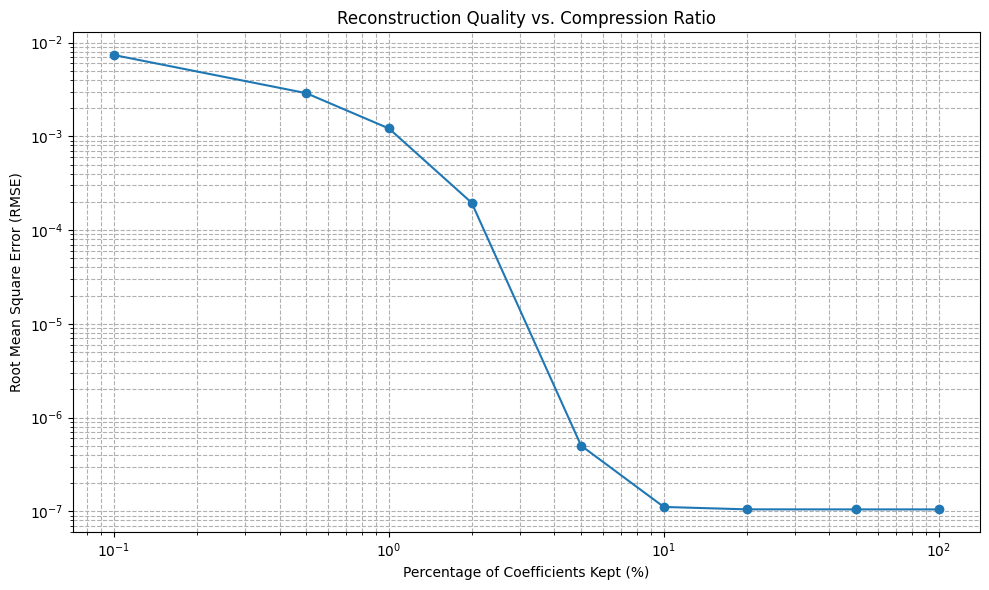

In [56]:
# Run the analysis
results_df = run_thresholding_analysis(
    volume, coeff_array, coeff_slices, WAVELET_TYPE, THRESHOLDS_PCT
)

# Display results in a table
display_df("Thresholding RMSE vs. Kept Coefficients", results_df)

# Plot the trade-off curve
plt.figure(figsize=(10, 6))
plt.plot(results_df['kept_pct'], results_df['rmse'], marker='o', linestyle='-')
plt.title('Reconstruction Quality vs. Compression Ratio')
plt.xlabel('Percentage of Coefficients Kept (%)')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


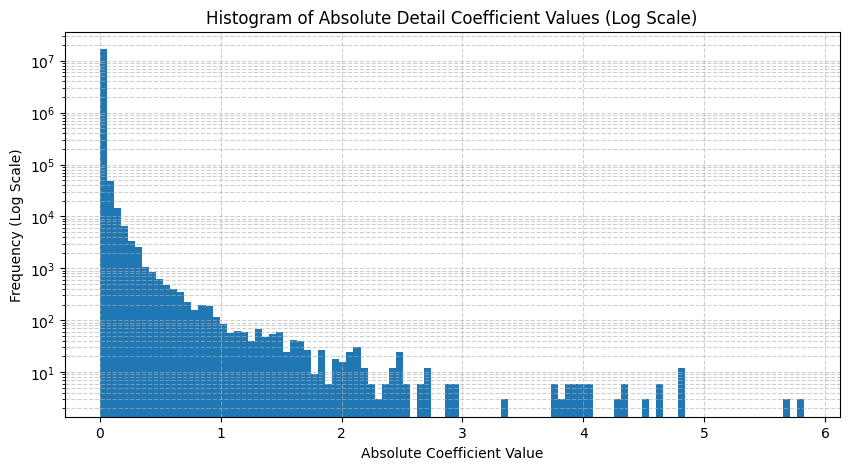

In [57]:
detail_coeffs = np.concatenate([
    arr.ravel() for detail_level in coeffs_struct[1:] for arr in detail_level.values()
])

plt.figure(figsize=(10, 5))
plt.hist(np.abs(detail_coeffs), bins=100, log=True)
plt.title('Histogram of Absolute Detail Coefficient Values (Log Scale)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

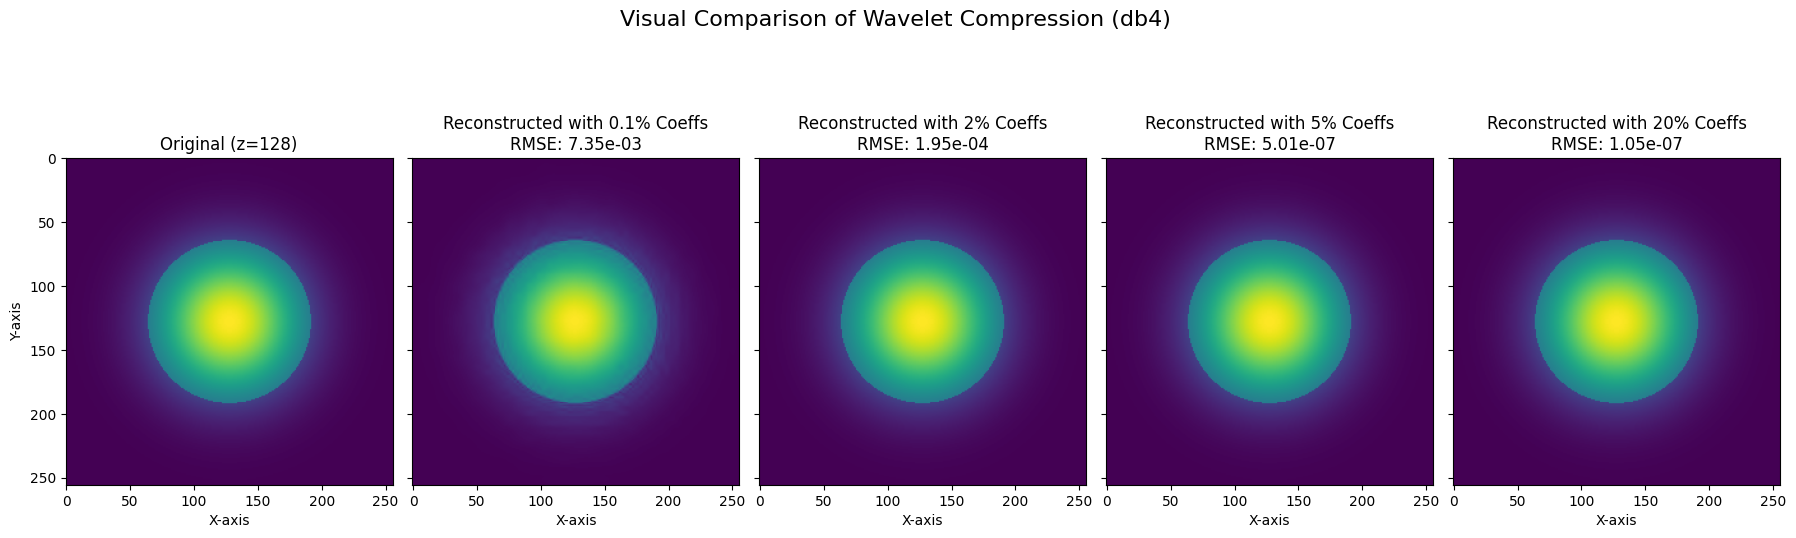

In [58]:
# Choose percentages to visualize from our results
viz_pct = [p for p in [0.1, 2, 5, 20] if p in results_df['kept_pct'].values]

fig, axes = plt.subplots(1, len(viz_pct) + 1, figsize=(18, 6), sharey=True)

# Plot original
ax = axes[0]
im = ax.imshow(volume[:, :, slice_idx], cmap='viridis')
ax.set_title(f'Original (z={slice_idx})')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
# fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Add colorbar if desired

# Get global min/max for consistent color scaling
vmin = volume[:, :, slice_idx].min()
vmax = volume[:, :, slice_idx].max()

for i, pct in enumerate(viz_pct):
    row = results_df[results_df['kept_pct'] == pct].iloc[0]
    
    # Re-run the reconstruction for this specific percentage
    n_coeffs_to_keep = int(row['kept_coeffs'])
    flat_coeffs = coeff_array.ravel()
    sorted_indices = np.argsort(np.abs(flat_coeffs))[::-1]
    mask = np.zeros_like(flat_coeffs, dtype=bool)
    if n_coeffs_to_keep > 0:
      mask[sorted_indices[:n_coeffs_to_keep]] = True
    truncated_flat = np.zeros_like(flat_coeffs)
    truncated_flat[mask] = flat_coeffs[mask]
    truncated_array = truncated_flat.reshape(coeff_array.shape)
    reconstructed_volume = waverec3(truncated_array, coeff_slices, WAVELET_TYPE)
    
    # Plot reconstructed slice
    ax = axes[i + 1]
    im = ax.imshow(reconstructed_volume[:, :, slice_idx], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(f'Reconstructed with {pct}% Coeffs\nRMSE: {row["rmse"]:.2e}')
    ax.set_xlabel('X-axis')

fig.suptitle(f'Visual Comparison of Wavelet Compression ({WAVELET_TYPE})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
